In [1]:
import os
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_context('paper', font_scale=2)
sns.set_style('whitegrid')

# Setup

In [2]:
cd /atlas/u/kechoi/time-score-dre/

/atlas/u/kechoi/time-score-dre


In [3]:
import sde_lib
import torch.autograd as autograd
import math

In [4]:
def dict2namespace(config):
  namespace = argparse.Namespace()
  for key, value in config.items():
    if isinstance(value, dict):
      new_value = dict2namespace(value)
    else:
      new_value = value
    setattr(namespace, key, new_value)
  return namespace

In [6]:
import os
import yaml
import argparse
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

# config_path = '/atlas/u/kechoi/time-score-dre/mintnet/configs/mnist_nice.yml'
# with open(os.path.join('configs', config_path), 'r') as f:
#   config = yaml.load(f)
# config = dict2namespace(config)

# add device
image_size = 28
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# config.device = device

data_dir = '/atlas/u/kechoi/time-score-dre/'
train_transform = test_transform = transforms.Compose([
  transforms.Resize(image_size),
  transforms.ToTensor()
])
train_ds = MNIST(os.path.join(data_dir, 'datasets', 'mnist'),
                 train=True,
                 download=True,
                 transform=train_transform)
# subset to first 50K examples for train
train_indices = np.arange(50000)
train_ds = torch.utils.data.Subset(train_ds, train_indices)
eval_ds = MNIST(os.path.join(data_dir, 'datasets', 'mnist_test'),
                train=False, download=True,
                transform=test_transform)

# TODO: not set up for actual evaluation yet!
train_ds = torch.utils.data.DataLoader(
  train_ds, 64,
  shuffle=True, num_workers=4, drop_last=False)
eval_ds = torch.utils.data.DataLoader(
  eval_ds, 64,
  shuffle=False, num_workers=4,
  drop_last=False)

# train_ds, eval_ds, _ = get_encoded_dataset(config, False)
train_iter = iter(train_ds)  # pytype: disable=wrong-arg-types
eval_iter = iter(eval_ds)

/atlas/u/kechoi/software/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


---

# Load pre-trained flow

In [7]:
import os
import sys
import yaml

# TODO: get rid of hard-coding
sys.path.append('/atlas/u/kechoi/time-score-dre/mintnet')
from mintnet.models.cnn_flow import DataParallelWithSampling
from mintnet.models.cnn_flow import Net
from mintnet.models.nice import NICE

In [8]:
import sys
sys.path.append('/atlas/u/kechoi/time-score-dre/nsf/')
from nsf.nde import distributions, transforms, flows

In [23]:
from nsf.experiments.images_centering import (
  create_transform, 
  create_flow,
  get_train_valid_data,
  get_data_stats,
  get_test_data
)

In [11]:
def load_pretrained_flow(name, test=False):
  print('loading flow model: {}'.format(name))
  # TODO: get rid of hard-coding
  config_path = '/atlas/u/kechoi/time-score-dre/mintnet/configs/'
  if name in ['mintnet', 'nice']:
    if name == 'mintnet':
      config_path = os.path.join(config_path, 'mnist_mintnet.yml')
      model_cls = Net
      ckpt_path = '/atlas/u/kechoi/time-score-dre/flow_ckpts/mintnet_checkpoint.pth'
    else:
      config_path = os.path.join(config_path, 'mnist_nice.yml')
      model_cls = NICE
      # the one that is used is a better-trained NICE flow than the commented one
      # ckpt_path = '/atlas/u/kechoi/time-score-dre/flow_ckpts/nice_checkpoint.pth'
      ckpt_path = '/atlas/u/kechoi/time-score-dre/flow_ckpts/bs32_nice_checkpoint.pth'
    print('loading model from checkpoint: {}'.format(ckpt_path))
    logging.info('loading model from checkpoint: {}'.format(ckpt_path))
    with open(os.path.join('configs', config_path), 'r') as f:
      config = yaml.load(f)
    new_config = dict2namespace(config)

    # add device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device(
      'cpu')
    new_config.device = device

    # load pretrained model
    net = model_cls(new_config).to(new_config.device)
    net = DataParallelWithSampling(net)

    # doesn't seem to have been trained with EMA
    # if new_config.training.ema:
    #   ema_helper = EMAHelper(mu=0.999)
    #   ema_helper.register(net)

    # load checkpoint
    states = torch.load(ckpt_path, map_location=new_config.device)
    net.load_state_dict(states[0])
  # this is with centering data
  elif name == 'rq_nsf':
    # 12 is no dropout, 11 is dropout
    ckpt_path = '/atlas/u/kechoi/time-score-dre/nsf/runs/images/mnist-8-bit-12/flow_best.pt'
    print('loading model from checkpoint: {}'.format(ckpt_path))
    
    # get other things
    train_dataset, val_dataset, (c, h, w) = get_train_valid_data('mnist', 8, .01)
    train_mean, val_mean = get_data_stats(train_dataset, val_dataset)
    test_dataset, (c, h, w) = get_test_data('mnist', 8)
    _, test_mean = get_data_stats(test_dataset, test_dataset, train=False)
    train_mean = train_mean.cuda()
    test_mean = test_mean.cuda()

    # annoying data transforms
    c = 1
    h = w = 28
    spline_params = {
    "apply_unconditional_transform": False,
    "min_bin_height": 0.001,
    "min_bin_width": 0.001,
    "min_derivative": 0.001,
    "num_bins": 8,
    "tail_bound": 3.0
    }
    distribution = distributions.StandardNormal((c * h * w,))
    # TODO (HACK): get rid of hardcoding (beware of hyperparams)
    train_transform, test_transform, transform = create_transform(c, h, w,
                                 train_mean, test_mean,
                                 levels=2, hidden_channels=64, steps_per_level=8, alpha=0.000001,
                                 num_bits=8, preprocessing="realnvp_2alpha", multi_scale=False,
                                 actnorm=True, coupling_layer_type="rational_quadratic_spline",
                                 spline_params=spline_params,
                                 use_resnet=False, num_res_blocks=2, resnet_batchnorm=False, dropout_prob=0.)

    net = flows.Flow(transform, distribution)

    # load checkpoint
    checkpoint = torch.load(ckpt_path)
    net.load_state_dict(checkpoint)
    net = net.to('cuda')
#     net = torch.nn.DataParallel(net)
  elif name == 'rq_nsf_copula':
    import pickle
    from nsf.experiments.images_centering_copula import create_transform

    # ckpt_path = '/atlas/u/kechoi/time-score-dre/nsf/runs/images/mnist-8-bit-2/flow_best.pt'
    # ckpt_path = '/atlas/u/kechoi/time-score-dre/nsf/runs/images/mnist-8-bit-6/flow_last.pt'
    ckpt_path = '/atlas/u/kechoi/time-score-dre/nsf/runs/images/mnist-8-bit-10/flow_best.pt'
    print('loading model from checkpoint: {}'.format(ckpt_path))

    # load data stats, no need to load a separate checkpoint
    if not test:
      with open('/atlas/u/kechoi/time-score-dre/nsf/runs/images/mnist-8-bit-10/data_means.p', 'rb') as fp:
          data_stats = pickle.load(fp)
      val_mean = data_stats['val_mean']
    else:  # val_mean = test_mean here
      print('loading test statistics for flow evaluation!')
      with open('/atlas/u/kechoi/time-score-dre/nsf/runs/images/mnist-8-bit-10/test_data_means.p', 'rb') as fp:
          data_stats = pickle.load(fp)
      val_mean = data_stats['test_mean']

    # stats
    train_mean = data_stats['train_mean']
    train_std = data_stats['train_std']

    # from torchvision.datasets import MNIST
    # from datasets import logit_transform
    # import torchvision
    # data_dir = '/atlas/u/kechoi/time-score-dre/'
    # test_transform = torchvision.transforms.Compose([
    #   torchvision.transforms.Resize(config.data.image_size),
    #   torchvision.transforms.ToTensor()
    # ])
    # dataset = MNIST(os.path.join(data_dir, 'datasets', 'mnist_test'),
    #                 train=False,
    #                 download=True,
    #                 transform=test_transform)
    # data = dataset.data.unsqueeze(1).float()
    # # dequantize
    # data = (data + torch.rand_like(data)) / 256.
    # data = logit_transform(data)
    # val_mean = data.mean(0)  # lol will this make a diff? no

    # annoying data transforms
    c = 1
    h = w = 28
    spline_params = {
    "apply_unconditional_transform": False,
    "min_bin_height": 0.001,
    "min_bin_width": 0.001,
    "min_derivative": 0.001,
    "num_bins": 128,
    "tail_bound": 3.0
    }
    distribution = distributions.StandardNormal((c * h * w,))

    train_transform, val_transform, transform = create_transform(
      c, h, w, train_mean, val_mean, train_std, levels=2, hidden_channels=64,
      steps_per_level=8, alpha=0.000001, num_bits=8, preprocessing="realnvp_2alpha",
      multi_scale=False, actnorm=True, coupling_layer_type="rational_quadratic_spline",
      spline_params=spline_params, use_resnet=False, num_res_blocks=2,
      resnet_batchnorm=False, dropout_prob=0.0)

    # net = flows.Flow(transform, distribution)
    net = flows.FlowDataTransform(transform, distribution, train_transform, val_transform)

    # load checkpoint
    checkpoint = torch.load(ckpt_path)
    # net.load_state_dict(checkpoint)

    # TODO: this is only for testing purposes! will go away if you train again
    xs = {'_train_transform.'+k: v for k, v in train_transform.state_dict().items()}
    ys = {'_val_transform.'+k: v for k, v in val_transform.state_dict().items()}
    new_state_dict = {**checkpoint, **xs, **ys}
    net.load_state_dict(new_state_dict)

    net = net.to('cuda')
#     net = torch.nn.DataParallel(net)
  else:
    assert name == 'realnvp'
    ckpt_path = '/atlas/u/kechoi/time-score-dre/flow_ckpts/real_nvp_mnist_best.pth.tar'
    print('loading model from checkpoint: {}'.format(ckpt_path))

    net = RealNVP(num_scales=2, in_channels=1, mid_channels=64,
                  num_blocks=8)
    net = net.to('cuda')
    net = torch.nn.DataParallel(net)

    # load checkpoint
    checkpoint = torch.load(ckpt_path)
    net.load_state_dict(checkpoint['net'])

  return net

In [12]:
flow = load_pretrained_flow('rq_nsf_copula', test=True)
flow.eval()

loading flow model: rq_nsf_copula
loading model from checkpoint: /atlas/u/kechoi/time-score-dre/nsf/runs/images/mnist-8-bit-10/flow_best.pt
loading test statistics for flow evaluation!


/atlas/u/kechoi/time-score-dre/nsf/nde/transforms/standard.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('_shift', torch.tensor(shift if (shift is not None) else 0.))


FlowDataTransform(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0): AffineTransformv3()
              (1): AffineTransform()
              (2): PiecewiseRationalQuadraticCDF()
              (3): AffineTransform()
              (4): NaiveLinear()
            )
          )
        )
      )
    )
  )
  (_distribution): StandardNormal()
  (_train_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineScalarTransform()
      (1): AffineScalarTransform()
      (2): Logit(
        (_transform): Sigmoid()
      )
      (3): AffineScalarTransform()
      (4): ReshapeTransform()
    )
  )
  (_val_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineScalarTransform()
      (1): AffineScalarTransform()
      (2): Logit(
        (_transform): Sigmoid()
      )
      (3): A

In [13]:
flow.eval()

FlowDataTransform(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0): AffineTransformv3()
              (1): AffineTransform()
              (2): PiecewiseRationalQuadraticCDF()
              (3): AffineTransform()
              (4): NaiveLinear()
            )
          )
        )
      )
    )
  )
  (_distribution): StandardNormal()
  (_train_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineScalarTransform()
      (1): AffineScalarTransform()
      (2): Logit(
        (_transform): Sigmoid()
      )
      (3): AffineScalarTransform()
      (4): ReshapeTransform()
    )
  )
  (_val_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineScalarTransform()
      (1): AffineScalarTransform()
      (2): Logit(
        (_transform): Sigmoid()
      )
      (3): A

---

In [ ]:
# count trainable parameters

In [15]:
flow

FlowDataTransform(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0): AffineTransformv3()
              (1): AffineTransform()
              (2): PiecewiseRationalQuadraticCDF()
              (3): AffineTransform()
              (4): NaiveLinear()
            )
          )
        )
      )
    )
  )
  (_distribution): StandardNormal()
  (_train_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineScalarTransform()
      (1): AffineScalarTransform()
      (2): Logit(
        (_transform): Sigmoid()
      )
      (3): AffineScalarTransform()
      (4): ReshapeTransform()
    )
  )
  (_val_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineScalarTransform()
      (1): AffineScalarTransform()
      (2): Logit(
        (_transform): Sigmoid()
      )
      (3): A

In [23]:
params = []
for param in flow._transform.named_parameters():
  print(param[0], param[1].size())
  params.append(param[1])

_transforms.0._transforms.0._transforms.1._shift torch.Size([784])
_transforms.0._transforms.0._transforms.1._scale torch.Size([784])
_transforms.0._transforms.0._transforms.2.unnormalized_widths torch.Size([784, 128])
_transforms.0._transforms.0._transforms.2.unnormalized_heights torch.Size([784, 128])
_transforms.0._transforms.0._transforms.2.unnormalized_derivatives torch.Size([784, 127])
_transforms.0._transforms.0._transforms.3._shift torch.Size([784])
_transforms.0._transforms.0._transforms.3._scale torch.Size([784])
_transforms.0._transforms.0._transforms.4.bias torch.Size([784])
_transforms.0._transforms.0._transforms.4._weight torch.Size([784, 784])


In [25]:
def to_numpy(x):
  return x.data.cpu().detach().numpy()

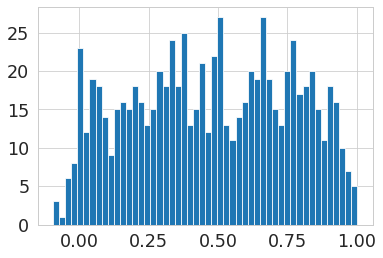

In [29]:
%matplotlib inline
_ = plt.hist(to_numpy(params[0]), bins=50)

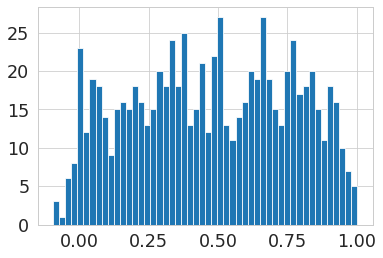

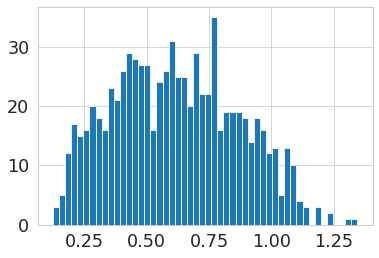

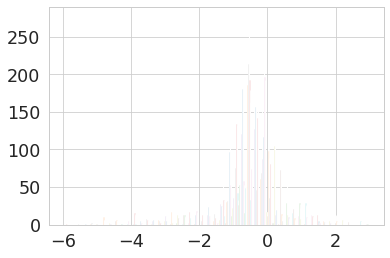

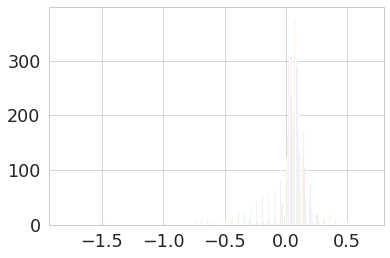

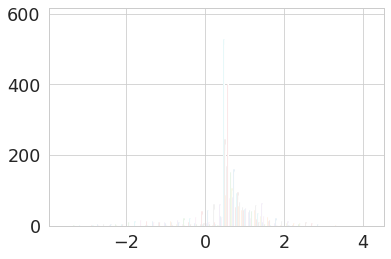

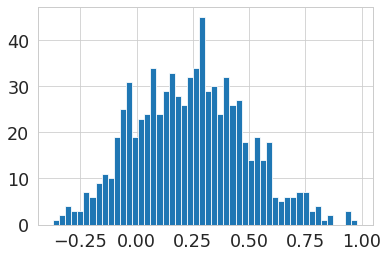

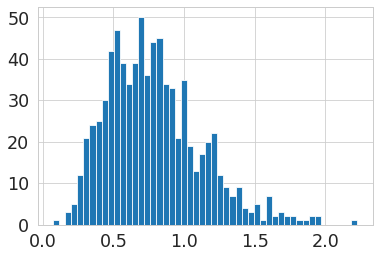

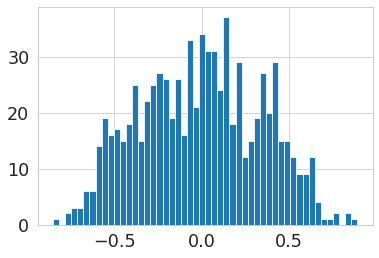

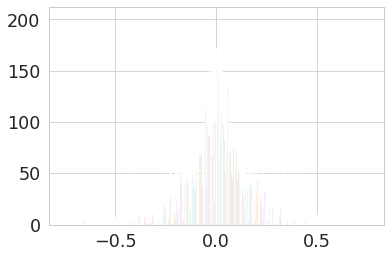

In [31]:
for i in range(len(params)):
  _ = plt.hist(to_numpy(params[i]), bins=50)
  plt.show()

In [21]:
param[1]

Parameter containing:
tensor([ 7.9419e-01, -1.5293e-02,  5.8415e-01,  1.9036e-01,  3.1336e-01,
         2.5546e-01,  8.2028e-01,  7.5404e-01,  4.5437e-02,  4.3729e-01,
         5.1247e-01,  4.9208e-01,  4.5808e-01,  4.8156e-01,  2.1146e-01,
         3.1749e-01,  2.2660e-01,  4.1800e-01,  5.2052e-01,  8.0487e-01,
         8.4792e-01,  1.3530e-02,  8.1728e-01, -8.1670e-02,  8.2826e-01,
         8.8928e-01,  3.0212e-01,  8.5861e-01,  7.8422e-01,  5.5188e-02,
         4.2150e-01,  8.0987e-01,  7.7677e-01,  9.7780e-01,  7.6083e-01,
         3.7214e-01,  2.4807e-01,  1.1064e-02,  4.9835e-01,  7.5476e-01,
         7.4287e-01,  6.9735e-01,  5.8349e-01,  2.4126e-02,  4.1822e-01,
         2.0494e-01,  6.3655e-01,  7.6782e-01,  4.0116e-01,  3.6284e-01,
         3.7732e-01,  6.8597e-02,  1.0242e-01,  2.0811e-01,  5.6302e-02,
         8.1290e-01,  3.3269e-01,  5.4742e-01,  2.9157e-01,  9.3790e-02,
        -7.6443e-02,  9.2272e-01,  5.0189e-01,  8.3974e-01,  4.8259e-01,
         2.2423e-01,  7.3296e

In [33]:
1210404

1210404

In [34]:
sum(p.numel() for p in flow.parameters() if p.requires_grad)

1178292

In [ ]:
# pytorch
1178292

# tensorflow
1210404

In [35]:
1210404 - 1178292

32112

In [56]:
1210404 - 1182180

28224

In [57]:
1210404 - 1184228

26176

In [37]:
p

Parameter containing:
tensor([1.4573, 1.4812, 1.6723, 0.8203, 0.8528, 0.8621, 0.8217, 0.8634, 1.3903,
        0.8866, 2.0291, 1.2595, 1.5606, 0.9010, 1.4004, 0.7887],
       device='cuda:0', requires_grad=True)

In [43]:
list(flow.named_parameters())[0][0]

'_transform._transforms.0._transforms.1._transforms.0.log_scale'

In [51]:
p[1].shape.numel()

16

In [55]:
tot = 0
for p in flow.named_parameters():
  if p[1].requires_grad:
    print(p[0], ':', p[1].shape, '', p[1].numel())
    tot += p[1].shape.numel()
    print('tot: {}'.format(tot))

_transform._transforms.0._transforms.1._transforms.0.log_scale : torch.Size([4])  4
tot: 4
_transform._transforms.0._transforms.1._transforms.0.shift : torch.Size([4])  4
tot: 8
_transform._transforms.0._transforms.1._transforms.1.bias : torch.Size([4])  4
tot: 12
_transform._transforms.0._transforms.1._transforms.1.lower_entries : torch.Size([6])  6
tot: 18
_transform._transforms.0._transforms.1._transforms.1.upper_entries : torch.Size([6])  6
tot: 24
_transform._transforms.0._transforms.1._transforms.1.unconstrained_upper_diag : torch.Size([4])  4
tot: 28
_transform._transforms.0._transforms.1._transforms.2.transform_net.net.0.weight : torch.Size([64, 2, 3, 3])  1152
tot: 1180
_transform._transforms.0._transforms.1._transforms.2.transform_net.net.0.bias : torch.Size([64])  64
tot: 1244
_transform._transforms.0._transforms.1._transforms.2.transform_net.net.3.weight : torch.Size([64, 64, 1, 1])  4096
tot: 5340
_transform._transforms.0._transforms.1._transforms.2.transform_net.net.3.bia

----

# Load data

In [12]:
pwd

'/atlas/u/kechoi/time-score-dre'

In [13]:
device = 'cuda'
import copy
from models.utils import get_score_fn, get_time_score_fn
from losses import get_time_score_estimate

In [14]:
def logit_transform(image):
  lambd = 1e-6
  image = lambd + (1 - 2 * lambd) * image
  return torch.log(image) - torch.log1p(-image)


def get_data_scaler():
    return lambda x: x * 2. - 1.


def get_data_inverse_scaler():
    return lambda x: (x + 1.) / 2.

In [15]:
scaler = get_data_scaler()
inverse_scaler = get_data_inverse_scaler()

In [16]:
device = 'cuda:0'

In [17]:
# does this also happen on the training set??
flow.eval()
# eval_batch, _ = next(train_iter)
eval_batch, _ = next(eval_iter)
print(eval_batch.min(), eval_batch.max())

# need to do data transformation with the flow
eval_batch = eval_batch.to(device).float() * 255. / 256.
eval_batch += torch.rand_like(eval_batch) / 256.
eval_batch = scaler(eval_batch)

tensor(0.) tensor(1.)


In [18]:
# maybe this is bc it's a bad flow...? (NICE)
print(eval_batch.min(), eval_batch.max())

tensor(-1.0000, device='cuda:0') tensor(1.0000, device='cuda:0')


In [19]:
z_batch = (eval_batch + 1.) / 2.

# Pass through flow

In [20]:
print(z_batch.min(), z_batch.max())

tensor(5.9605e-08, device='cuda:0') tensor(1.0000, device='cuda:0')


In [21]:
z_batch *= 256.

In [22]:
z_batch = flow.module.transform_to_noise(z_batch, context=None)
z_batch = z_batch.view(eval_batch.size())

In [23]:
z_batch.size()

torch.Size([64, 1, 28, 28])

In [24]:
z_batch.min()

tensor(-3.4220, device='cuda:0', grad_fn=<MinBackward1>)

In [25]:
z_batch.max()

tensor(4.2954, device='cuda:0', grad_fn=<MaxBackward1>)

In [26]:
# now try sampling
with torch.no_grad():
  xt = flow.module.sample(z_batch.view(z_batch.size(0), -1))

In [27]:
xt.size()

torch.Size([64, 1, 28, 28])

In [28]:
print(xt.min(), xt.max())

tensor(-1.0000, device='cuda:0') tensor(1.0000, device='cuda:0')


# prior_log_p

In [29]:
eval_batch.size()

torch.Size([64, 1, 28, 28])

In [30]:
print(eval_batch.min(), eval_batch.max())

tensor(-1.0000, device='cuda:0') tensor(1.0000, device='cuda:0')


In [31]:
x = eval_batch

# evaluates log p(x), where p(x) is a flow trained on MNIST
n = x.size(0)
shape = x.shape
N = np.prod(shape[1:])
with torch.no_grad():
  flow.eval()
  x = (x + 1.) / 2.
  x *= 256.
  # automatically gives you N(0,I) log porbability + all the transformations
  log_p = flow.module._log_prob(x, context=None)

In [32]:
log_p

tensor([-473.9811, -571.2052, -283.5872, -658.7700, -537.7698, -303.0933,
        -600.9478, -550.1787, -637.5796, -705.4351, -689.2832, -775.5645,
        -554.7825, -639.5021, -195.5388, -683.4736, -601.7542, -509.7871,
        -792.9944, -488.0315, -557.6920, -525.2885, -600.6516, -600.0527,
        -573.0840, -728.2312, -458.6936, -518.8071, -605.5979, -308.6138,
        -526.0781, -264.1450, -564.2437, -663.1194, -517.7346, -736.6074,
        -565.8015, -279.2668, -583.9272, -330.5635, -236.2866, -512.1133,
        -493.4816, -491.9413, -450.6150, -638.8999, -351.2726, -646.9307,
        -539.0155, -562.4788, -543.7146, -698.8940, -679.0281, -645.7028,
        -785.1622, -568.5912, -593.4594, -275.0391, -581.6586, -556.6262,
        -328.1572, -710.3114, -506.2484, -561.5027])

In [33]:
# we need another log_det for undoing the rescaling operation
log_p = log_p - N * np.log(2)

In [ ]:
# TODO: i think we may need another operation for multiplying back the 256.

In [34]:
log_p

tensor([-1017.4084, -1114.6326,  -827.0145, -1202.1974, -1081.1971,  -846.5206,
        -1144.3751, -1093.6061, -1181.0070, -1248.8624, -1232.7106, -1318.9918,
        -1098.2098, -1182.9294,  -738.9662, -1226.9010, -1145.1815, -1053.2145,
        -1336.4218, -1031.4589, -1101.1194, -1068.7158, -1144.0790, -1143.4801,
        -1116.5114, -1271.6586, -1002.1210, -1062.2345, -1149.0253,  -852.0411,
        -1069.5055,  -807.5724, -1107.6710, -1206.5468, -1061.1620, -1280.0348,
        -1109.2289,  -822.6942, -1127.3546,  -873.9908,  -779.7140, -1055.5406,
        -1036.9089, -1035.3687,  -994.0424, -1182.3273,  -894.7000, -1190.3580,
        -1082.4429, -1105.9061, -1087.1420, -1242.3214, -1222.4554, -1189.1301,
        -1328.5896, -1112.0186, -1136.8867,  -818.4664, -1125.0859, -1100.0536,
         -871.5846, -1253.7388, -1049.6758, -1104.9301])